In [397]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import torch.utils.data as data
import matplotlib.pyplot as plt 

# Target high-dim performance functions

In [480]:
from juan_first_passage import juan_first_passage
#https://rprepo.readthedocs.io/en/latest/reliability_problems.html#sec-rp-300
# RP300 14 input variables - gaussian
#set_id 	 problem_id
# 1 	 15

from gfun_213_le_frame import gfun_213_le_frame
from le_frame import le_frame
import le_frame_rein
# https://rprepo.readthedocs.io/en/latest/_modules/gfun_213_le_frame.html#gfun_213_le_frame
# set_id	problem_id
# 1 	14

# Creating classes for MLP and AutoEncoder (AE) and Variational AE

In [880]:
# class to create an Autoencoder object
class AE(torch.nn.Module):
    def __init__(self, in_dim):
        
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        
        self.encoder = torch.nn.Sequential(
            nn.Linear(in_dim, 10),
            nn.LeakyReLU(0.1),
            nn.Linear(10, 7),
            nn.LeakyReLU(0.1),
            nn.Linear(7, 5),
            nn.LeakyReLU(0.1),
            nn.Linear(5, 3),
            )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        
        self.decoder = torch.nn.Sequential(
            nn.Linear(3, 5),
            nn.LeakyReLU(0.1),
            nn.Linear(5, 7),
            nn.LeakyReLU(0.1),
            nn.Linear(7, 10),
            nn.LeakyReLU(0.1),
            nn.Linear(10, in_dim),
            )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [678]:
# class to create an MLP object
class MLP(nn.Sequential):
    def __init__(self, input_features, hidden_features, output_features):
        super().__init__(
            nn.Linear(input_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, output_features),
        )

In [901]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, in_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(in_dim)
                
        self.decoder = torch.nn.Sequential(
        nn.Linear(3, 5),
        nn.LeakyReLU(0.1),
        nn.Linear(5, 7),
        nn.LeakyReLU(0.1),
        nn.Linear(7, 10),
        nn.LeakyReLU(0.1),
        nn.Linear(10, in_dim),
        )
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class VariationalEncoder(nn.Module):
    def __init__(self, in_dim):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(in_dim, 8)
        self.linear2 = nn.Linear(8, 3)
        self.linear3 = nn.Linear(8, 3)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self, x):
#         x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [886]:
# VariationalAutoencoder(14)

Generating samples and splitting the data for training and test

In [623]:
n_samples = 10**6

# x_dataset_2 = np.random.normal(0, 1 , size=(n_samples, 14) )

# y_dataset_2 = juan_first_passage(x_dataset_2)

### pf estimation with dataset
np.sum(y_dataset_2 < 0)/len(y_dataset_2)

5e-05

In [619]:
# reading external dataset file 
# filename_data = 'DataSet_RP300_10e5.sav'
# dataset = pickle.load(open(filename_data, 'rb'))
# x_dataset = dataset[:, 0:14]
# y_dataset = dataset[:, 14]

In [721]:
# dataset[:, 0:14] = x_dataset
# dataset[:, 14] = y_dataset

# filename_data = 'DataSet_RP300_10e5.sav'
# pickle.dump(dataset, open(filename_data, 'wb'))

n_split = int(0.3 * n_samples) #splitting 30 - 70 %

x_train = torch.from_numpy(x_dataset[n_split:].astype(np.float32))
y_train = torch.from_numpy(y_dataset[n_split:].astype(np.float32)).view(-1,1)

x_test = torch.from_numpy(x_dataset[:n_split].astype(np.float32))
y_test = torch.from_numpy(y_dataset[:n_split].astype(np.float32)).view(-1,1)

Setting up losses criterion, optimizer and dataloaders

In [891]:
if torch.cuda.is_available() == True:
    device = 'cuda'
else:
    device = 'cpu'
    
print(device)

cuda


# Training MLP

In [809]:
#  instantiate the network  
network = MLP(14, 28, 1)    #input, hidden, output size

print(network)

MLP(
  (0): Linear(in_features=14, out_features=28, bias=True)
  (1): ReLU()
  (2): Linear(in_features=28, out_features=28, bias=True)
  (3): ReLU()
  (4): Linear(in_features=28, out_features=28, bias=True)
  (5): ReLU()
  (6): Linear(in_features=28, out_features=1, bias=True)
)


In [785]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network.parameters(), lr = 1e-2, weight_decay = 1e-8)

train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=64, shuffle=True)

test = data.TensorDataset(x_test, y_test)
testloader = data.DataLoader(test, batch_size=64, shuffle=True)

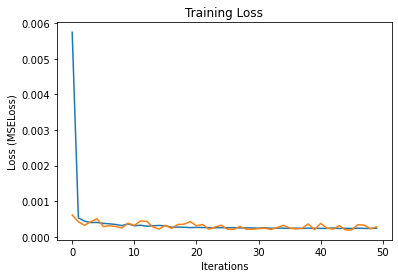

In [786]:
num_epochs = 50
train_avg_loss = []
test_avg_loss = []

device = 'cpu'

network.to(device)

for i in range(num_epochs):

    train_losses = []
    test_losses = []

    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        
        pred = network(x)
        loss = criterion(pred, y)
        train_losses.append(loss.detach())

        optimizer.zero_grad()   #turning gradients to zero
        loss.backward()         #to get the gradient only with respect the parameters
        optimizer.step()        #to update the network parameters

    with torch.no_grad():   

        for x, y in testloader:
            x = x.to(device)
            y = y.to(device)
            
            pred = network(x)
            loss = criterion(pred, y)
            test_losses.append(loss)

    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))

# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSE)')
plt.show()

In [799]:
filename_data = 'network_MLP.sav'
pickle.dump(network, open(filename_data, 'wb'))

# Training AE

In [881]:
#model initialization
network_AE = AE(14)   #size of high-dim input space
print(network_AE)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=14, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=10, out_features=7, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=7, out_features=5, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=5, out_features=7, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=7, out_features=10, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=10, out_features=14, bias=True)
  )
)


In [882]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network_AE.parameters(), lr = 1e-3, weight_decay = 1e-8)

train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=80, shuffle=True)

test = data.TensorDataset(x_test, y_test)
testloader = data.DataLoader(test, batch_size=80, shuffle=False)

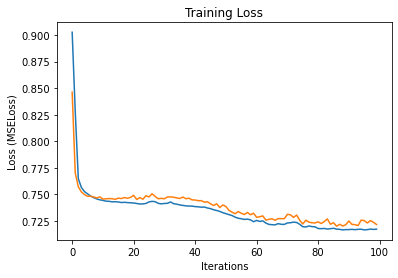

In [883]:
num_epochs = 100
train_avg_loss = []
test_avg_loss = []

for i in range(num_epochs):

    train_losses = []
    test_losses = []

    for x, _ in trainloader:    #we can omit 'y' value 

        reconstructed = network_AE(x)
        loss = criterion(reconstructed, x)
        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():   

        for x, _ in testloader:

            reconstructed = network_AE(x)
            loss = criterion(reconstructed, x)
            test_losses.append(loss)

    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))
    
fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

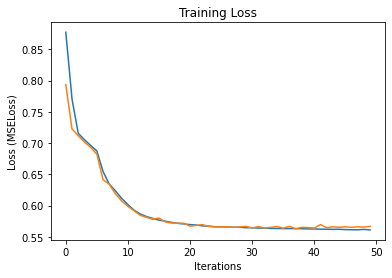

In [838]:
#lr = 1e-3, batchsize=128, weight_decay = 1e-8
#latent = 5

# (encoder): Sequential(
#     (0): Linear(in_features=14, out_features=12, bias=True)
#     (1): LeakyReLU(negative_slope=0.1)
#     (2): Linear(in_features=12, out_features=10, bias=True)
#     (3): LeakyReLU(negative_slope=0.1)
#     (4): Linear(in_features=10, out_features=7, bias=True)
#     (5): LeakyReLU(negative_slope=0.1)
#     (6): Linear(in_features=7, out_features=5, bias=True)
#   )

# fig, axs = plt.subplots(1, 1)
# axs.set_title('Training Loss')
# axs.plot(train_avg_loss)
# axs.plot(test_avg_loss)
# axs.set_xlabel('Iterations')
# axs.set_ylabel('Loss (MSELoss)')
# plt.show()

# VAE

In [903]:
# VariationalAutoencoder(14)

#model initialization
network_VAE = VariationalAutoencoder(14)   #size of high-dim input space
print(network_VAE)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=14, out_features=8, bias=True)
    (linear2): Linear(in_features=8, out_features=3, bias=True)
    (linear3): Linear(in_features=8, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=5, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=5, out_features=7, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=7, out_features=10, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=10, out_features=14, bias=True)
  )
)


In [904]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network_AE.parameters(), lr = 1e-3, weight_decay = 1e-8)

train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=128, shuffle=True)

test = data.TensorDataset(x_test, y_test)
testloader = data.DataLoader(test, batch_size=128, shuffle=False)

In [ ]:
num_epochs = 50
train_avg_loss = []
test_avg_loss = []

device = 'cuda'

network_VAE.to(device)

for i in range(num_epochs):

    train_losses = []
    test_losses = []

    for x, _ in trainloader:    #we can omit 'y' value 
        x = x.to(device) # GPU
        
        reconstructed = network_VAE(x)
        loss = criterion(reconstructed, x)+ network_VAE.encoder.kl
        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():   

        for x, _ in testloader:
            x = x.to(device) # GPU
            
            reconstructed = network_VAE(x)
            loss = criterion(reconstructed, x)
            test_losses.append(loss)

    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))

# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

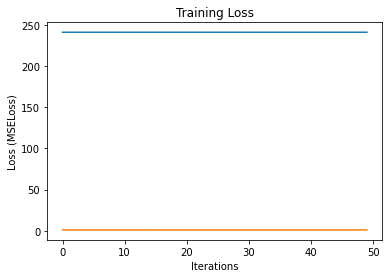

In [898]:
fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

Pf estimation

In [828]:
# #loading network
# filename_data = 'network_MLP.sav'
# network = pickle.load(open(filename_data, 'rb'))

In [830]:
point = 10
samplex = torch.from_numpy(x_dataset[point].astype(np.float32)).to(device)

y_dataset[point], network(samplex)

(0.7378826462902384, tensor([0.7547], grad_fn=<AddBackward0>))

In [831]:
np.sum(y_dataset < 0)/len(y_dataset)

5e-05

In [832]:
n_pred = 10**6
# x_pred = np.random.rand(n_pred, 14)
x_pred = torch.randn(n_pred, 14, device=device)

y_pred = network(x_pred)   #MLP

np.sum(y_pred.cpu().detach().numpy() < 0)

# np.sum(y_pred < 0)/len(y_pred)

0

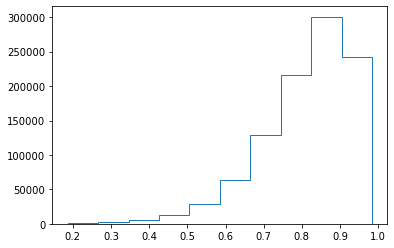

In [834]:
counts, bins = np.histogram(y_pred.cpu().detach().numpy())
plt.stairs(counts, bins)

In [587]:
np.sum(y_pred.cpu().detach().numpy() < 0)

0

In [603]:
negative = y_pred < 0
negative.sum(dim = 0)

tensor([0])

In [454]:
point = 10
samplex = x_dataset[point]
sampley = y_dataset[point]

samplex_torch = torch.from_numpy(x_dataset[point].astype(np.float32))

In [463]:
np.array(sampley)

array(0.92380366)

In [466]:
(torch.from_numpy(np.array(sampley)) - network(samplex_torch))**2

tensor([0.0004], grad_fn=<PowBackward0>)